In [1]:
import os
import argparse
import time
from datetime import datetime, date
import random

import numpy as np
from scipy.sparse import load_npz
from scipy.stats import pearsonr
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc
import pandas as pd

import torch
import torch_geometric

from model_classes_ import GCN_classification, GCN_regression, MLP_Classification, MLP_Regression

In [2]:
def train_model_classification(model, graph, max_epoch, learning_rate, targetNode_mask, train_idx, valid_idx, optimizer, name='GCN'):
    '''
    Trains model for classification task
    
    Parameters
    ----------
    model [GCN_classification]: Instantiation of model class
    graph [PyG Data class]: PyTorch Geometric Data object representing the graph
    max_epoch [int]: Maximum number of training epochs
    learning_rate [float]: Learning rate
    targetNode_mask [tensor]: Subgraph mask for training nodes
    train_idx [array]: Node IDs corresponding to training set
    valid_idx [array]: Node IDs corresponding to validation set
    optimizer [PyTorch optimizer class]: PyTorch optimization algorithm

    Returns
    -------
    train_loss_vec [array]: Training loss for each epoch
    train_AUROC_vec [array]: Training AUROC score for each epoch
    valid_loss_vec [array]: Validation loss for each epoch
    valid_AUROC_vec [array]: Validation AUROC score for each epoch

    '''
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = model.to(device)
    graph = graph.to(device)

    optimizer = optimizer
    
    train_labels = to_cpu_npy(graph.y[targetNode_mask[train_idx]])
    valid_labels = to_cpu_npy(graph.y[targetNode_mask[valid_idx]])
    
    train_loss_list = []
    train_AUROC_vec = np.zeros(np.shape(np.arange(max_epoch)))
    valid_loss_list = []
    valid_AUROC_vec = np.zeros(np.shape(np.arange(max_epoch)))

    model.train()
    train_status = True
    
    print('\n')
    for e in list(range(max_epoch)):
        
        if e%100 == 0:
            print("Epoch", str(e), 'out of', str(max_epoch))
        
        model.train()
        train_status = True
        
        optimizer.zero_grad()
        
        ### Only trains on nodes with genes due to masking
        if name == 'GCN':
            forward_scores = model(graph.x.float(), graph.edge_index, train_status)[targetNode_mask]
            train_scores = forward_scores[train_idx]
        elif name == 'MLP':
            forward_scores = model(graph.x.float())[targetNode_mask]
            train_scores = forward_scores[train_idx].squeeze()        

        train_loss  = model.loss(train_scores, torch.LongTensor(train_labels).to(device))

        train_softmax, _ = model.calc_softmax_pred(train_scores)

        train_loss.backward()
        
        optimizer.step()
            
        ### Calculate training and validation loss, AUROC scores
        model.eval()
        
        valid_scores = forward_scores[valid_idx]
        valid_loss  = model.loss(valid_scores, torch.LongTensor(valid_labels).to(device))
        valid_softmax, _ = model.calc_softmax_pred(valid_scores) 

        train_loss_list.append(train_loss.item())
        train_softmax = to_cpu_npy(train_softmax)
        train_AUROC = roc_auc_score(train_labels, train_softmax[:,1], average="micro")

        valid_loss_list.append(valid_loss.item())
        valid_softmax = to_cpu_npy(valid_softmax)
        valid_AUROC = roc_auc_score(valid_labels, valid_softmax[:,1], average="micro")
        
        train_AUROC_vec[e] = train_AUROC
        valid_AUROC_vec[e] = valid_AUROC

    train_loss_vec = np.reshape(np.array(train_loss_list), (-1, 1))
    valid_loss_vec = np.reshape(np.array(valid_loss_list), (-1, 1))

    return train_loss_vec, train_AUROC_vec, valid_loss_vec, valid_AUROC_vec


def eval_model_classification(model, graph, targetNode_mask, train_idx, valid_idx, test_idx, name='GCN'):
    '''
    Runs fully trained classification model and compute evaluation statistics

    Parameters
    ----------
    model [GCN_classification]: Instantiation of model class
    graph [PyG Data class]: PyTorch Geometric Data object representing the graph
    targetNode_mask [tensor]: Mask ensuring model only trains on nodes with genes
    train_idx [array]: Node IDs corresponding to training set;
        analogous for valid_idx and test_idx

    Returns
    -------
    test_AUROC [float]: Test set AUROC score;
        analogous for train_AUROC (training set) and valid_AUPR (validation set)
    test_AUPR [float]: Test set AUPR score
        analogous for train_AUPR (training set) and valid_AUPR (validation set)
    test_pred [array]: Test set predictions;
        analogous for train_pred (training set) and valid_pred (validation set)
    test_labels [array]: Test set labels;
        analagous for train_labels (training set) and valid_labels (validation set)
    '''
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = model.to(device)
    graph = graph.to(device)
    test_labels = to_cpu_npy(graph.y[targetNode_mask[test_idx]])
    
    model.eval()
    train_status=False

    if name == 'GCN':
        forward_scores = model(graph.x.float(), graph.edge_index, train_status)[targetNode_mask]
    elif name == 'MLP':
        forward_scores = model(graph.x.float())[targetNode_mask]
    
    test_scores = forward_scores[test_idx]
    
    test_softmax, test_pred = model.calc_softmax_pred(test_scores) 
    
    test_softmax = to_cpu_npy(test_softmax)
    test_pred = to_cpu_npy(test_pred)
    test_AUROC = roc_auc_score(test_labels, test_softmax[:,1], average="micro")
    test_precision, test_recall, thresholds = precision_recall_curve(test_labels, test_softmax[:,1])
    test_AUPR = auc(test_recall, test_precision)
    # test_F1 = f1_score(test_labels, test_pred, average="micro")
    
    train_scores = forward_scores[train_idx]
    train_labels = to_cpu_npy(graph.y[targetNode_mask[train_idx]])
    train_softmax, train_pred = model.calc_softmax_pred(train_scores) 
    train_pred = to_cpu_npy(train_pred)
    train_softmax = to_cpu_npy(train_softmax)
    train_precision, train_recall, thresholds = precision_recall_curve(train_labels, train_softmax[:,1])
    train_AUPR = auc(train_recall, train_precision)
    # train_F1 = f1_score(train_labels, train_pred, average="micro")

    valid_scores = forward_scores[valid_idx]
    valid_labels = to_cpu_npy(graph.y[targetNode_mask[valid_idx]])
    valid_softmax, valid_pred = model.calc_softmax_pred(valid_scores) 
    valid_pred = to_cpu_npy(valid_pred)
    valid_softmax = to_cpu_npy(valid_softmax)
    valid_precision, valid_recall, thresholds = precision_recall_curve(valid_labels, valid_softmax[:,1])
    valid_AUPR = auc(valid_recall, valid_precision)
    # valid_F1 = f1_score(valid_labels, valid_pred, average="micro")

    return test_AUROC, test_AUPR, test_pred, test_labels, train_AUPR, train_pred, train_labels, \
        valid_AUPR, valid_pred, valid_labels


def train_model_regression(model, graph, max_epoch, learning_rate, targetNode_mask, train_idx, valid_idx, optimizer, name='GCN'):
    '''
    Trains model for regression task
    
    Parameters
    ----------
    model [GCN_classification]: Instantiation of model class
    graph [PyG Data class]: PyTorch Geometric Data object representing the graph
    max_epoch [int]: Maximum number of training epochs
    learning_rate [float]: Learning rate
    targetNode_mask [tensor]: Subgraph mask for training nodes
    train_idx [array]: Node IDs corresponding to training set
    valid_idx [array]: Node IDs corresponding to validation set
    optimizer [PyTorch optimizer class]: PyTorch optimization algorithm

    Returns
    -------
    train_loss_vec [array]: Training loss for each epoch;
        analagous for valid_loss_vec (validation set)
    train_pearson_vec [array]: Training PCC for each epoch;
        analogous for valid_pearson_vec (validation set)
    '''
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = model.to(device)
    graph = graph.to(device)

    optimizer = optimizer
    
    train_labels = to_cpu_npy(graph.y[targetNode_mask[train_idx]])
    valid_labels = to_cpu_npy(graph.y[targetNode_mask[valid_idx]])
    
    train_loss_list = []
    train_pearson_vec = np.zeros(np.shape(np.arange(max_epoch)))
    valid_loss_list = []
    valid_pearson_vec = np.zeros(np.shape(np.arange(max_epoch)))

    model.train()
    train_status = True
    
    print('\n')
    for e in list(range(max_epoch)):
        
        if e%100 == 0:
            print("Epoch", str(e), 'out of', str(max_epoch))
        
        model.train()
        train_status = True
        
        optimizer.zero_grad()
        
        ### Only trains on nodes with genes due to masking
        if name == 'GCN':
            forward_scores = model(graph.x.float(), graph.edge_index, train_status)[targetNode_mask]
            train_scores = forward_scores[train_idx]
        elif name == 'MLP':
            forward_scores = model(graph.x.float())[targetNode_mask]
            train_scores = forward_scores[train_idx].squeeze()
        
        

        train_loss  = model.loss(train_scores, torch.FloatTensor(train_labels).to(device))

        train_loss.backward()
        
        optimizer.step()
            
        ### Calculate training and validation loss, AUROC scores
        model.eval()
        
        train_scores = to_cpu_npy(train_scores)
        train_pearson = calc_pearson(train_scores, train_labels)
        train_loss_list.append(train_loss.item())
        
        valid_scores = forward_scores[valid_idx]
        valid_loss  = model.loss(valid_scores, torch.FloatTensor(valid_labels).to(device))
        valid_scores = to_cpu_npy(valid_scores)
        valid_pearson  = calc_pearson(valid_scores, valid_labels)
        valid_loss_list.append(valid_loss.item())
        
        train_pearson_vec[e] = train_pearson
        valid_pearson_vec[e] = valid_pearson

    train_loss_vec = np.reshape(np.array(train_loss_list), (-1, 1))
    valid_loss_vec = np.reshape(np.array(valid_loss_list), (-1, 1))

    return train_loss_vec, train_pearson_vec, valid_loss_vec, valid_pearson_vec


def eval_model_regression(model, graph, targetNode_mask, train_idx, valid_idx, test_idx, name='GCN'):
    '''
    Runs fully trained regression model and compute evaluation statistics

    Parameters
    ----------
    model [GCN_classification]: Instantiation of model class
    graph [PyG Data class]: PyTorch Geometric Data object representing the graph
    targetNode_mask [tensor]: Mask ensuring model only trains on nodes with genes
    train_idx [array]: Node IDs corresponding to training set;
        analogous for valid_idx and test_idx

    Returns
    -------
    test_pearson [float]: PCC for test set;
        analogous for train_pearson (training set) and valid_pearson (validation set)
    test_pred [array]: Test set predictions;
        analogous for train_pred (training set) and valid_pred (validation set)
    test_labels [array]: Test set labels (expression values);
        analagous for train_labels (training set) and valid_labels (validation set)

    '''
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = model.to(device)
    graph = graph.to(device)
    
    model.eval()
    train_status=False

    if name == 'GCN':
        forward_scores = model(graph.x.float(), graph.edge_index, train_status)[targetNode_mask]
    elif name == 'MLP':
        forward_scores = model(graph.x.float())[targetNode_mask]

    test_scores = forward_scores[test_idx]
    test_pred = to_cpu_npy(test_scores)
    test_labels = to_cpu_npy(graph.y[targetNode_mask[test_idx]])
    test_pearson = calc_pearson(test_pred, test_labels)

    train_scores = forward_scores[train_idx]
    train_pred = to_cpu_npy(train_scores)
    train_labels = to_cpu_npy(graph.y[targetNode_mask[train_idx]])
    train_pearson = calc_pearson(train_pred, train_labels)

    valid_scores = forward_scores[valid_idx]
    valid_pred = to_cpu_npy(valid_scores)
    valid_labels = to_cpu_npy(graph.y[targetNode_mask[valid_idx]])
    valid_pearson = calc_pearson(valid_pred, valid_labels)

    return test_pearson, test_pred, test_labels, train_pearson, train_pred, train_labels, \
        valid_pearson, valid_pred, valid_labels
        

def calc_pearson(scores, targets):
    '''
    Calculates Pearson correlation coefficient (PCC) between predicted \
        expression levels and true expression levels

    Parameters
    ----------
    scores [array]: Predicted expression levels
    targets [array]: True expression levels

    Returns
    -------
    pcc [float]: Pearson correlation coefficient

    '''
    scores = scores.squeeze()
    targets = targets.squeeze()
    pcc, _ = pearsonr(scores, targets)
            
    return pcc
    
    
def to_cpu_npy(x):
    '''
    Simple helper function to transfer GPU tensors to CPU numpy matrices

    Parameters
    ----------
    x [tensor]: PyTorch tensor stored on GPU

    Returns
    -------
    new_x [array]: Numpy array stored on CPU

    '''

    new_x = x.cpu().detach().numpy()
    
    return new_x

In [3]:
chip_res = 10000
hic_res = 10000
num_hm = 6
num_feat = int((hic_res/chip_res)*num_hm)

In [4]:
# This function trains and evaluates models
###Test for GPU availability
cuda_flag = torch.cuda.is_available()
if cuda_flag:  
  dev = "cuda" 
else:
  dev = "cpu"  
device = torch.device(dev)  

In [5]:
def experiment(cell_line, regression_flag, model, max_epoch=200, learning_rate=0.001, name='GCN'):
    """
    
        Trains and evaluates models.
        
        Parameters:
        cell_line: cell line to be trained on
        regression_flag: 0 (Classification) or 1 (Regression)
        model: GCN, MLP, or CNN model
        name: GCN, MLP, CNN
        
        Returns:
        Performance scores based on type of task
        
    """
    if regression_flag == 0:
        num_classes = 2
        task = 'Classification'
    else:
        num_classes = 1
        task = 'Regression'

    # random_seed = random.randint(0,10000)
    random.seed(random_seed)
    np.random.seed(random_seed)
    torch.manual_seed(random_seed)


    ###Initialize start time
    start_time = time.time()

    today = date.today()
    mdy = today.strftime("%Y-%m-%d")
    clock = datetime.now()
    hms = clock.strftime("%H-%M-%S")
    hm = clock.strftime("%Hh-%Mm")
    hm_colon = clock.strftime("%H:%M")
    date_and_time = mdy + '-at-' + hms
    
    ###Load input files
    base_path = os.getcwd()
    save_dir = os.path.join(base_path, 'data', cell_line, 'saved_runs')
    hic_sparse_mat_file = os.path.join(base_path, 'data', cell_line, 'hic_sparse.npz')
    np_nodes_lab_genes_file = os.path.join(base_path, 'data',  cell_line, \
        'np_nodes_lab_genes_reg' + str(regression_flag) + '.npy')
    np_hmods_norm_all_file = os.path.join(base_path, 'data', cell_line, \
        'np_hmods_norm_chip_' + str(chip_res) + 'bp.npy')
    df_genes_file = os.path.join(base_path, 'data', cell_line, 'df_genes_reg' + str(regression_flag) + '.pkl')
    df_genes = pd.read_pickle(df_genes_file)
    
    # Provide hyperparameters
#     print(os.path.basename(__file__))
    print('Model date and time:')
    print(date_and_time, '\n\n')
    print('Cell line:', cell_line)
    print('Task:', task)
    print('ChIP-seq resolution:', str(chip_res))
    print('\n')
    print('Training set: 70%')
    print('Validation set: 15%')
    print('Testing set: 15%')
    print('\n')
    print('Model hyperparameters: ')
    print('Number of epochs:', max_epoch)
    print('Learning rate:', learning_rate)
    
    # Load data
    mat = load_npz(hic_sparse_mat_file)
    allNodes_hms = np.load(np_hmods_norm_all_file)
    hms = allNodes_hms[:, 1:] #only includes features, not node ids
    X = torch.tensor(hms).float().reshape(-1, num_feat) 
    allNodes = allNodes_hms[:, 0].astype(int)
    geneNodes_labs = np.load(np_nodes_lab_genes_file)

    geneNodes = geneNodes_labs[:, -2].astype(int)
    allLabs = -1*np.ones(np.shape(allNodes))

    targetNode_mask = torch.tensor(geneNodes).long()

    if regression_flag == 0:
        geneLabs = geneNodes_labs[:, -1].astype(int)
        allLabs[geneNodes] = geneLabs
        Y = torch.tensor(allLabs).long()
    else:
        geneLabs = geneNodes_labs[:, -1].astype(float)
        allLabs[geneNodes] = geneLabs
        Y = torch.tensor(allLabs).float()

    extract = torch_geometric.utils.from_scipy_sparse_matrix(mat)
    data = torch_geometric.data.Data(edge_index = extract[0], edge_attr = extract[1], x = X, y = Y)
    G = data
    
    # Define convolutional and linear layer input/output sizes
    graph_conv_layer_sizes = [num_feat] + \
        [int(max(graph_conv_embed_size, lin_hidden_size)) \
              for i in np.arange(1, num_graph_conv_layers, 1)] + [lin_hidden_size]

    lin_hidden_sizes = [graph_conv_layer_sizes[-1]] + \
        [int(max(lin_hidden_size, num_classes)) \
              for i in np.arange(1, num_lin_layers, 1)] + [num_classes]
    
    # Randomize node order and split into 70%/15%/15% training/validation/test sets
    pred_idx_shuff = torch.randperm(targetNode_mask.shape[0])

    fin_train = np.floor(0.7*pred_idx_shuff.shape[0]).astype(int)
    fin_valid = np.floor(0.85*pred_idx_shuff.shape[0]).astype(int)
    train_idx = pred_idx_shuff[:fin_train]
    valid_idx = pred_idx_shuff[fin_train:fin_valid]
    test_idx = pred_idx_shuff[fin_valid:]

    train_gene_ID = targetNode_mask[train_idx].numpy()
    valid_gene_ID = targetNode_mask[valid_idx].numpy()
    test_gene_ID = targetNode_mask[test_idx].numpy()
    
    optimizer = torch.optim.Adam(filter(lambda p : p.requires_grad, model.parameters()), lr = learning_rate)
    print("\n"+"Model's state_dict:")
    for param_tensor in model.state_dict():
        print(param_tensor, "\t", model.state_dict()[param_tensor].size())
    
    ### For classification:
    if regression_flag == 0:

        ### Train model
        train_loss_vec, train_AUROC_vec, valid_loss_vec, valid_AUROC_vec = \
            train_model_classification(model, G, max_epoch, learning_rate, targetNode_mask, train_idx, valid_idx, optimizer, name=name)

        ### Evaluate model
        test_AUROC, test_AUPR, test_pred, test_labels, train_AUPR, train_pred, train_labels, \
                valid_AUPR, valid_pred, valid_labels = \
                    eval_model_classification(model, G, targetNode_mask, train_idx, valid_idx, test_idx, name=name)

        ### Save metrics and node predictions
        train_metrics = [train_gene_ID, train_pred, train_labels, train_AUROC_vec, train_AUPR, train_loss_vec]
        # np.save(os.path.join(save_dir, 'model_' + date_and_time + '_train_metrics'  + '.npy'), train_metrics)

        valid_metrics = [valid_gene_ID, valid_pred, valid_labels, valid_AUROC_vec, valid_AUPR, valid_loss_vec]
        # np.save(os.path.join(save_dir, 'model_' + date_and_time + '_valid_metrics'  + '.npy'), valid_metrics)

        test_metrics = [test_gene_ID, test_pred, test_labels, test_AUROC, test_AUPR, ['na']]
        # np.save(os.path.join(save_dir, 'model_' + date_and_time + '_test_metrics'  + '.npy'), test_metrics)

        dataset_list = [train_metrics, valid_metrics, test_metrics]
        df_full_metrics = pd.DataFrame(columns=['Dataset','Node ID','True Label','Predicted Label','Classification'])

        for d in np.arange(len(dataset_list)):
            dataset_metrics = dataset_list[d]
            partial_metrics = pd.DataFrame()

            partial_metrics['Node ID'] = dataset_metrics[0]
            partial_metrics['True Label'] = dataset_metrics[2]
            partial_metrics['Predicted Label'] = dataset_metrics[1]
            partial_metrics['Classification'] = dataset_metrics[1]*1 + dataset_metrics[2]*2
            partial_metrics['Classification'].replace(to_replace=0, value='TN', inplace=True)
            partial_metrics['Classification'].replace(to_replace=1, value='FP', inplace=True)
            partial_metrics['Classification'].replace(to_replace=2, value='FN', inplace=True)
            partial_metrics['Classification'].replace(to_replace=3, value='TP', inplace=True)

            if d == 0:
                partial_metrics['Dataset'] = 'Training'
            elif d == 1:
                partial_metrics['Dataset'] = 'Validation'
            elif d == 2:
                partial_metrics['Dataset'] = 'Testing'

            df_full_metrics = pd.concat([df_full_metrics, partial_metrics], ignore_index=True)

        df_gene_names = df_genes.iloc[:,:3]
        df_gene_names = df_gene_names.rename(columns={"gene_catalog_name": "ENSEMBL_ID", "abbrev": "Abbreviation",
                                      "hic_node_id" : 'Node ID'})
        df_full_metrics = pd.merge(df_full_metrics, df_gene_names, how='inner', on='Node ID')
        df_full_metrics = df_full_metrics[df_full_metrics.columns[[0,1,5,6,2,3,4]]]

    ### For regression:
    elif regression_flag == 1:

        ### Train model
        train_loss_vec, train_pearson_vec, valid_loss_vec, valid_pearson_vec = \
            train_model_regression(model, G, max_epoch, learning_rate, targetNode_mask, train_idx, valid_idx, optimizer, name=name)

        ### Evaluate model
        test_pearson, test_pred, test_labels, train_pearson, train_pred, train_labels, \
                valid_pearson, valid_pred, valid_labels = \
                    eval_model_regression(model, G, targetNode_mask, train_idx, valid_idx, test_idx, name=name)

        ### Save metrics and node predictions
        train_metrics = [train_gene_ID, train_pred, train_labels, train_pearson_vec, train_loss_vec]
        # np.save(os.path.join(save_dir, 'model_' + date_and_time + '_train_metrics'  + '.npy'), train_metrics)

        valid_metrics = [valid_gene_ID, valid_pred, valid_labels, valid_pearson_vec, valid_loss_vec]
        # np.save(os.path.join(save_dir, 'model_' + date_and_time + '_valid_metrics'  + '.npy'), valid_metrics)

        test_metrics = [test_gene_ID, test_pred, test_labels, test_pearson, ['na']]
        # np.save(os.path.join(save_dir, 'model_' + date_and_time + '_test_metrics'  + '.npy'), test_metrics)

        dataset_list = [train_metrics, valid_metrics, test_metrics]
        df_full_metrics = pd.DataFrame(columns=['Dataset','Node ID','True Label','Predicted Label'])

        for d in np.arange(len(dataset_list)):
            dataset_metrics = dataset_list[d]
            partial_metrics = pd.DataFrame()

            partial_metrics['Node ID'] = dataset_metrics[0]
            partial_metrics['True Label'] = dataset_metrics[2]
            partial_metrics['Predicted Label'] = dataset_metrics[1]

            if d == 0:
                partial_metrics['Dataset'] = 'Training'
            elif d == 1:
                partial_metrics['Dataset'] = 'Validation'
            elif d == 2:
                partial_metrics['Dataset'] = 'Testing'

            df_full_metrics = pd.concat([df_full_metrics, partial_metrics], ignore_index=True)

        df_gene_names = df_genes.iloc[:,:3]
        df_gene_names = df_gene_names.rename(columns={"gene_catalog_name": "ENSEMBL_ID", "abbrev": "Abbreviation",
                                      "hic_node_id" : 'Node ID'})
        df_full_metrics = pd.merge(df_full_metrics, df_gene_names, how='inner', on='Node ID')
        df_full_metrics = df_full_metrics[df_full_metrics.columns[[0,1,4,5,2,3]]]


    ### Print elapsed time and performance
    elapsed = (time.time() - start_time)
    elapsed_h = int(elapsed//3600)
    elapsed_m = int((elapsed - elapsed_h*3600)//60)
    elapsed_s = int(elapsed - elapsed_h*3600 - elapsed_m*60)
    print('Elapsed time: {0:02d}:{1:02d}:{2:02d}'.format(elapsed_h, elapsed_m, elapsed_s))
    
    ### Save trained model parameters, model predictions CSV file, model performance/information
    model_path = os.path.join(save_dir, 'model_' + date_and_time + '.pt')
    torch.save(model.state_dict(), model_path)

    df_full_metrics_filename = os.path.join(save_dir, 'model_predictions_GCN_' + date_and_time + '.csv')
    df_full_metrics.to_csv(df_full_metrics_filename, index=False)

    model_info_filename = os.path.join(save_dir,'model_' + date_and_time + '_info.txt')
    f = open(model_info_filename, 'w')
#     f.write('File name: ' + os.path.basename(__file__) + '\n')
    f.write('Model reference date and time: ' + date_and_time + '\n\n')
    f.write('Start date: ' + mdy + '\n')
    f.write('Start time: ' + hm_colon + '\n')
    f.write('Total time: {0:02d}:{1:02d}:{2:02d}'.format(elapsed_h, elapsed_m, elapsed_s))
    f.write('\n\n')
    f.write('Task: ' + task + '\n')
    f.write('Cell line: ' + cell_line + '\n')
    f.write('Dataset split:\n')
    f.write('Training set: 70%' + '\n')
    f.write('Validation set: 15%' + '\n')
    f.write('Testing set: 15%' + '\n\n')
    f.write('Performance:\n')
    if regression_flag == 0:
        f.write('Test AUROC: ' + str(test_AUROC) + '\n')
        f.write('Test AUPR: ' + str(test_AUPR) + '\n\n')
    elif regression_flag == 1:
        f.write('Test PCC: ' + str(test_pearson) + '\n\n')
    f.write('Hyperparameters:\n')
    f.write('Number of epochs: ' + str(max_epoch) + '\n')
    f.write('Learning rate :' + str(learning_rate) + '\n')
    f.write('Number of graph convolutional layers: ' + str(num_graph_conv_layers) + '\n')
    f.write('Graph convolutional layer size: ' + str(graph_conv_embed_size) + '\n')
    f.write('Number of linear layers: ' + str(num_lin_layers) + '\n')
    f.write('Linear hidden layer size: ' + str(lin_hidden_size) + '\n\n')
    f.write('Model\'s state_dict:\n')

    for param_tensor in model.state_dict():
        f.write(str(param_tensor) + "\t" + str(model.state_dict()[param_tensor].size()) + '\n')
    f.close()
    
    print('\nPerformance:')
    if regression_flag == 0:
        
        print('Test AUROC:', test_AUROC, '\n')
        print('Test AUPR:', test_AUPR, '\n\n')
        return (test_AUROC, test_AUPR)
    
    elif regression_flag == 1:
        print('Test pearson:', test_pearson, '\n')
        return test_pearson


    


In [6]:
# Stores AUROC, AUPR, and PCC across all models for each cell line
data_dict = {}
data_dict['E116'] = []
data_dict['E122'] = []
data_dict['E123'] = []

## MLP Model

In [7]:
# Set random seed

random_seed = random.randint(0,10000)
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)

In [8]:
# Hyperparameters
regression_flag = 0
max_epoch = 1000
learning_rate = 0.001
num_lin_layers = 2
lin_hidden_size = 100
num_graph_conv_layers = 2
graph_conv_embed_size = 256
for line in data_dict:
    cell_line = line
    
    regression_flag=0
    num_classes = 2
    task ='Classification'
    
    model = MLP_Classification(input_size=num_feat, hidden_sizes=[lin_hidden_size, lin_hidden_size], num_classes=num_classes)
    
    # MLP Classification Task
    MLP_AUROC, MLP_AUPR = experiment(cell_line=cell_line, regression_flag=0, learning_rate=learning_rate, model=model, name='MLP')
    
    regression_flag = 1
    num_classes = 1
    task ='Regression'
    
    model = MLP_Regression(input_size=num_feat, hidden_sizes=[lin_hidden_size, lin_hidden_size])
    
    # MLP Regression Task
    MLP_Pearson = experiment(cell_line=cell_line, regression_flag=1, learning_rate=learning_rate, model=model, name='MLP')
    data_dict[line].append([MLP_AUROC, MLP_AUPR, MLP_Pearson])

Model date and time:
2024-12-01-at-02-41-19 


Cell line: E116
Task: Classification
ChIP-seq resolution: 10000


Training set: 70%
Validation set: 15%
Testing set: 15%


Model hyperparameters: 
Number of epochs: 200
Learning rate: 0.001

Model's state_dict:
fc1.weight 	 torch.Size([100, 6])
fc1.bias 	 torch.Size([100])
fc2.weight 	 torch.Size([100, 100])
fc2.bias 	 torch.Size([100])
fc3.weight 	 torch.Size([2, 100])
fc3.bias 	 torch.Size([2])


Epoch 0 out of 200
Epoch 100 out of 200


/tmp/ipykernel_343/2956166977.py:153: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  partial_metrics['Classification'].replace(to_replace=0, value='TN', inplace=True)
/tmp/ipykernel_343/2956166977.py:153: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col]

Elapsed time: 00:00:11

Performance:
Test AUROC: 0.9104954653791779 

Test AUPR: 0.8974274784242036 


Model date and time:
2024-12-01-at-02-41-31 


Cell line: E116
Task: Regression
ChIP-seq resolution: 10000


Training set: 70%
Validation set: 15%
Testing set: 15%


Model hyperparameters: 
Number of epochs: 200
Learning rate: 0.001

Model's state_dict:
fc1.weight 	 torch.Size([100, 6])
fc1.bias 	 torch.Size([100])
fc2.weight 	 torch.Size([100, 100])
fc2.bias 	 torch.Size([100])
fc3.weight 	 torch.Size([1, 100])
fc3.bias 	 torch.Size([1])


Epoch 0 out of 200


/opt/conda/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([2505])) that is different to the input size (torch.Size([2505, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 100 out of 200


/tmp/ipykernel_343/2956166977.py:213: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_full_metrics = pd.concat([df_full_metrics, partial_metrics], ignore_index=True)


Elapsed time: 00:01:39

Performance:
Test pearson: 0.7555460178170035 

Model date and time:
2024-12-01-at-02-43-10 


Cell line: E122
Task: Classification
ChIP-seq resolution: 10000


Training set: 70%
Validation set: 15%
Testing set: 15%


Model hyperparameters: 
Number of epochs: 200
Learning rate: 0.001

Model's state_dict:
fc1.weight 	 torch.Size([100, 6])
fc1.bias 	 torch.Size([100])
fc2.weight 	 torch.Size([100, 100])
fc2.bias 	 torch.Size([100])
fc3.weight 	 torch.Size([2, 100])
fc3.bias 	 torch.Size([2])


Epoch 0 out of 200
Epoch 100 out of 200


/tmp/ipykernel_343/2956166977.py:153: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  partial_metrics['Classification'].replace(to_replace=0, value='TN', inplace=True)
/tmp/ipykernel_343/2956166977.py:153: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col]

Elapsed time: 00:00:08

Performance:
Test AUROC: 0.8873121869782972 

Test AUPR: 0.8502682313663789 


Model date and time:
2024-12-01-at-02-43-19 


Cell line: E122
Task: Regression
ChIP-seq resolution: 10000


Training set: 70%
Validation set: 15%
Testing set: 15%


Model hyperparameters: 
Number of epochs: 200
Learning rate: 0.001

Model's state_dict:
fc1.weight 	 torch.Size([100, 6])
fc1.bias 	 torch.Size([100])
fc2.weight 	 torch.Size([100, 100])
fc2.bias 	 torch.Size([100])
fc3.weight 	 torch.Size([1, 100])
fc3.bias 	 torch.Size([1])


Epoch 0 out of 200


/opt/conda/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([2502])) that is different to the input size (torch.Size([2502, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 100 out of 200


/tmp/ipykernel_343/2956166977.py:213: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_full_metrics = pd.concat([df_full_metrics, partial_metrics], ignore_index=True)


Elapsed time: 00:01:38

Performance:
Test pearson: 0.7124619711402225 

Model date and time:
2024-12-01-at-02-44-58 


Cell line: E123
Task: Classification
ChIP-seq resolution: 10000


Training set: 70%
Validation set: 15%
Testing set: 15%


Model hyperparameters: 
Number of epochs: 200
Learning rate: 0.001

Model's state_dict:
fc1.weight 	 torch.Size([100, 6])
fc1.bias 	 torch.Size([100])
fc2.weight 	 torch.Size([100, 100])
fc2.bias 	 torch.Size([100])
fc3.weight 	 torch.Size([2, 100])
fc3.bias 	 torch.Size([2])


Epoch 0 out of 200
Epoch 100 out of 200


/tmp/ipykernel_343/2956166977.py:153: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  partial_metrics['Classification'].replace(to_replace=0, value='TN', inplace=True)
/tmp/ipykernel_343/2956166977.py:153: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col]

Elapsed time: 00:00:07

Performance:
Test AUROC: 0.9292785595200111 

Test AUPR: 0.9046185660196655 


Model date and time:
2024-12-01-at-02-45-06 


Cell line: E123
Task: Regression
ChIP-seq resolution: 10000


Training set: 70%
Validation set: 15%
Testing set: 15%


Model hyperparameters: 
Number of epochs: 200
Learning rate: 0.001

Model's state_dict:
fc1.weight 	 torch.Size([100, 6])
fc1.bias 	 torch.Size([100])
fc2.weight 	 torch.Size([100, 100])
fc2.bias 	 torch.Size([100])
fc3.weight 	 torch.Size([1, 100])
fc3.bias 	 torch.Size([1])


Epoch 0 out of 200


/opt/conda/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([2503])) that is different to the input size (torch.Size([2503, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 100 out of 200


/tmp/ipykernel_343/2956166977.py:213: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_full_metrics = pd.concat([df_full_metrics, partial_metrics], ignore_index=True)


Elapsed time: 00:01:47

Performance:
Test pearson: 0.8046899008427632 



In [9]:
data_dict

{'E116': [[0.9104954653791779, 0.8974274784242036, 0.7555460178170035]],
 'E122': [[0.8873121869782972, 0.8502682313663789, 0.7124619711402225]],
 'E123': [[0.9292785595200111, 0.9046185660196655, 0.8046899008427632]]}

## GC-Merge Model

In [10]:
# Set random seed
random_seed = random.randint(0,10000)
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)

In [11]:
# Hyperparameters
regression_flag = 0
max_epoch = 1000
learning_rate = 0.001
num_lin_layers = 2
lin_hidden_size = 100
num_graph_conv_layers = 2
graph_conv_embed_size = 256

In [12]:
for line in data_dict:
    cell_line = line
    
    regression_flag=0
    num_classes = 2
    task='Classification'
    graph_conv_layer_sizes = [num_feat] + \
        [int(max(graph_conv_embed_size, lin_hidden_size)) \
              for i in np.arange(1, num_graph_conv_layers, 1)] + [lin_hidden_size]

    lin_hidden_sizes = [graph_conv_layer_sizes[-1]] + \
        [int(max(lin_hidden_size, num_classes)) \
              for i in np.arange(1, num_lin_layers, 1)] + [num_classes]
    
    model = GCN_classification(num_feat, num_graph_conv_layers, graph_conv_layer_sizes, num_lin_layers, lin_hidden_sizes, num_classes)
    
    # GCN Classification Task
    GCN_AUROC, GCN_AUPR = experiment(cell_line=cell_line, regression_flag=regression_flag, learning_rate=learning_rate, model=model)
    
    regression_flag = 1
    num_classes = 1
    task = 'Regression'
    
    graph_conv_layer_sizes = [num_feat] + \
        [int(max(graph_conv_embed_size, lin_hidden_size)) \
              for i in np.arange(1, num_graph_conv_layers, 1)] + [lin_hidden_size]

    lin_hidden_sizes = [graph_conv_layer_sizes[-1]] + \
        [int(max(lin_hidden_size, num_classes)) \
              for i in np.arange(1, num_lin_layers, 1)] + [num_classes]
    
    model = GCN_regression(num_feat, num_graph_conv_layers, graph_conv_layer_sizes, num_lin_layers, lin_hidden_sizes, num_classes)
    
    # GCN Regression Task
    GCN_Pearson = experiment(cell_line=cell_line, regression_flag=regression_flag, learning_rate=learning_rate, model=model)
    
    data_dict[line].append([GCN_AUROC, GCN_AUPR, GCN_Pearson])

Model date and time:
2024-12-01-at-02-46-54 


Cell line: E116
Task: Classification
ChIP-seq resolution: 10000


Training set: 70%
Validation set: 15%
Testing set: 15%


Model hyperparameters: 
Number of epochs: 200
Learning rate: 0.001

Model's state_dict:
conv1.lin_l.weight 	 torch.Size([256, 12])
conv1.lin_l.bias 	 torch.Size([256])
conv2.lin_l.weight 	 torch.Size([100, 512])
conv2.lin_l.bias 	 torch.Size([100])
lin1.weight 	 torch.Size([100, 100])
lin1.bias 	 torch.Size([100])
lin2.weight 	 torch.Size([2, 100])
lin2.bias 	 torch.Size([2])


Epoch 0 out of 200
Epoch 100 out of 200


/tmp/ipykernel_343/2956166977.py:153: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  partial_metrics['Classification'].replace(to_replace=0, value='TN', inplace=True)
/tmp/ipykernel_343/2956166977.py:153: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col]

Elapsed time: 00:00:38

Performance:
Test AUROC: 0.9181943614272166 

Test AUPR: 0.8977545575843013 


Model date and time:
2024-12-01-at-02-47-33 


Cell line: E116
Task: Regression
ChIP-seq resolution: 10000


Training set: 70%
Validation set: 15%
Testing set: 15%


Model hyperparameters: 
Number of epochs: 200
Learning rate: 0.001

Model's state_dict:
conv1.lin_l.weight 	 torch.Size([256, 12])
conv1.lin_l.bias 	 torch.Size([256])
conv2.lin_l.weight 	 torch.Size([100, 512])
conv2.lin_l.bias 	 torch.Size([100])
lin1.weight 	 torch.Size([100, 100])
lin1.bias 	 torch.Size([100])
lin2.weight 	 torch.Size([1, 100])
lin2.bias 	 torch.Size([1])


Epoch 0 out of 200
Epoch 100 out of 200


/tmp/ipykernel_343/2956166977.py:213: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_full_metrics = pd.concat([df_full_metrics, partial_metrics], ignore_index=True)


Elapsed time: 00:02:19

Performance:
Test pearson: 0.7792933534648159 

Model date and time:
2024-12-01-at-02-49-53 


Cell line: E122
Task: Classification
ChIP-seq resolution: 10000


Training set: 70%
Validation set: 15%
Testing set: 15%


Model hyperparameters: 
Number of epochs: 200
Learning rate: 0.001

Model's state_dict:
conv1.lin_l.weight 	 torch.Size([256, 12])
conv1.lin_l.bias 	 torch.Size([256])
conv2.lin_l.weight 	 torch.Size([100, 512])
conv2.lin_l.bias 	 torch.Size([100])
lin1.weight 	 torch.Size([100, 100])
lin1.bias 	 torch.Size([100])
lin2.weight 	 torch.Size([2, 100])
lin2.bias 	 torch.Size([2])


Epoch 0 out of 200
Epoch 100 out of 200


/tmp/ipykernel_343/2956166977.py:153: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  partial_metrics['Classification'].replace(to_replace=0, value='TN', inplace=True)
/tmp/ipykernel_343/2956166977.py:153: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col]

Elapsed time: 00:00:35

Performance:
Test AUROC: 0.9029902967269843 

Test AUPR: 0.8698255850775667 


Model date and time:
2024-12-01-at-02-50-29 


Cell line: E122
Task: Regression
ChIP-seq resolution: 10000


Training set: 70%
Validation set: 15%
Testing set: 15%


Model hyperparameters: 
Number of epochs: 200
Learning rate: 0.001

Model's state_dict:
conv1.lin_l.weight 	 torch.Size([256, 12])
conv1.lin_l.bias 	 torch.Size([256])
conv2.lin_l.weight 	 torch.Size([100, 512])
conv2.lin_l.bias 	 torch.Size([100])
lin1.weight 	 torch.Size([100, 100])
lin1.bias 	 torch.Size([100])
lin2.weight 	 torch.Size([1, 100])
lin2.bias 	 torch.Size([1])


Epoch 0 out of 200
Epoch 100 out of 200


/tmp/ipykernel_343/2956166977.py:213: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_full_metrics = pd.concat([df_full_metrics, partial_metrics], ignore_index=True)


Elapsed time: 00:02:05

Performance:
Test pearson: 0.7415007670441942 

Model date and time:
2024-12-01-at-02-52-34 


Cell line: E123
Task: Classification
ChIP-seq resolution: 10000


Training set: 70%
Validation set: 15%
Testing set: 15%


Model hyperparameters: 
Number of epochs: 200
Learning rate: 0.001

Model's state_dict:
conv1.lin_l.weight 	 torch.Size([256, 12])
conv1.lin_l.bias 	 torch.Size([256])
conv2.lin_l.weight 	 torch.Size([100, 512])
conv2.lin_l.bias 	 torch.Size([100])
lin1.weight 	 torch.Size([100, 100])
lin1.bias 	 torch.Size([100])
lin2.weight 	 torch.Size([2, 100])
lin2.bias 	 torch.Size([2])


Epoch 0 out of 200
Epoch 100 out of 200


/tmp/ipykernel_343/2956166977.py:153: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  partial_metrics['Classification'].replace(to_replace=0, value='TN', inplace=True)
/tmp/ipykernel_343/2956166977.py:153: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col]

Elapsed time: 00:00:36

Performance:
Test AUROC: 0.9272972514040938 

Test AUPR: 0.9047406579897443 


Model date and time:
2024-12-01-at-02-53-11 


Cell line: E123
Task: Regression
ChIP-seq resolution: 10000


Training set: 70%
Validation set: 15%
Testing set: 15%


Model hyperparameters: 
Number of epochs: 200
Learning rate: 0.001

Model's state_dict:
conv1.lin_l.weight 	 torch.Size([256, 12])
conv1.lin_l.bias 	 torch.Size([256])
conv2.lin_l.weight 	 torch.Size([100, 512])
conv2.lin_l.bias 	 torch.Size([100])
lin1.weight 	 torch.Size([100, 100])
lin1.bias 	 torch.Size([100])
lin2.weight 	 torch.Size([1, 100])
lin2.bias 	 torch.Size([1])


Epoch 0 out of 200
Epoch 100 out of 200


/tmp/ipykernel_343/2956166977.py:213: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_full_metrics = pd.concat([df_full_metrics, partial_metrics], ignore_index=True)


Elapsed time: 00:02:05

Performance:
Test pearson: 0.7967516595322902 



In [13]:
data_dict

{'E116': [[0.9104954653791779, 0.8974274784242036, 0.7555460178170035],
  [0.9181943614272166, 0.8977545575843013, 0.7792933534648159]],
 'E122': [[0.8873121869782972, 0.8502682313663789, 0.7124619711402225],
  [0.9029902967269843, 0.8698255850775667, 0.7415007670441942]],
 'E123': [[0.9292785595200111, 0.9046185660196655, 0.8046899008427632],
  [0.9272972514040938, 0.9047406579897443, 0.7967516595322902]]}

# CNN Model

In [14]:
# # Set random seed

# random_seed = random.randint(0,10000)
# random.seed(random_seed)
# np.random.seed(random_seed)
# torch.manual_seed(random_seed)

In [15]:
# # Hyperparameters
# cell_line = ...
# regression_flag = ...
# max_epoch = ...
# learning_rate = ...
# num_graph_conv_layers = ...
# graph_conv_embed_size = ...
# num_lin_layers = ...
# lin_hidden_size = ...

In [16]:
# if regression_flag == 0:
#     num_classes = 2
#     task = 'Classification'
# else:
#     num_classes = 1
#     task = 'Regression'

In [17]:
# model = SimpleCNN()

# NUM_SAMPLES = 100
# INPUT_LENGTH = 6   # Length of each input sequence
# NUM_CLASSES = 2    # Binary classification

# optimizer = optim.Adam(model.parameters(), lr=0.001)

# input_data = Your data

# target_labels = torch.randint(0, 2, (NUM_SAMPLES,))

# output = model(input_data)
# loss = criterion(output, target_labels)

# loss.backward()
# optimizer.step()

# dataset = TensorDataset(input_data, target_labels)
# data_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)


# num_epochs = 10
# for epoch in range(num_epochs):
#     epoch_loss = 0
#     for batch_inputs, batch_labels in data_loader:
#         optimizer.zero_grad()
        
#         output = model(batch_inputs)
#         loss = criterion(output, batch_labels)
        
#         loss.backward()
#         optimizer.step()
        
#         epoch_loss += loss.item()
    
#     avg_loss = epoch_loss / len(data_loader)
#     print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss:.4f}")

SyntaxError: invalid syntax (3238120964.py, line 9)

# Results

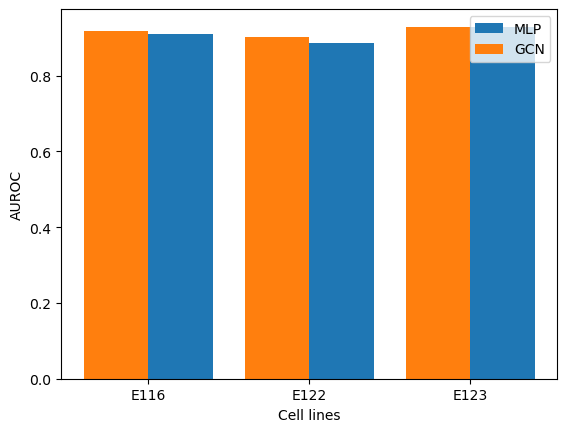

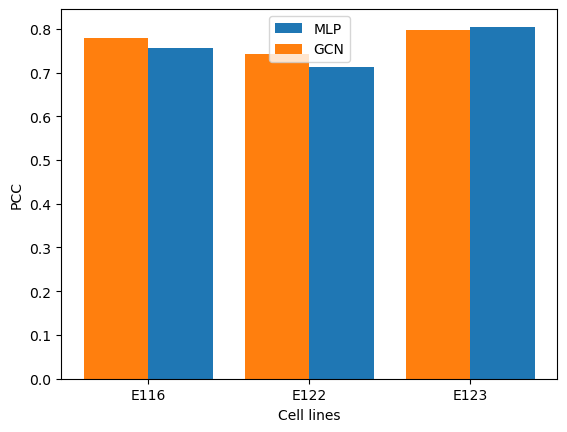

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# Extract the cell lines and their corresponding data
cell_lines = list(data_dict.keys())
categories = cell_lines
values = [[v[0] for v in data_dict[cell_lines[0]]], [v[0] for v in data_dict[cell_lines[1]]], [v[0] for v in data_dict[cell_lines[2]]]]
values

AUROC_MLP = [data_dict[line][0][0] for line in cell_lines]
PCC_MLP = [data_dict[line][0][2] for line in cell_lines]

AUROC_GCN = [data_dict[line][1][0] for line in cell_lines]
PCC_GCN = [data_dict[line][1][2] for line in cell_lines]

# AUROC graphs
X_axis = np.arange(0,len(categories))
plt.bar(X_axis + 0.2, AUROC_MLP, 0.4, label='MLP')
plt.bar(X_axis-0.2, AUROC_GCN, 0.4, label='GCN')
plt.xticks(X_axis, categories)
plt.xlabel("Cell lines")
plt.ylabel("AUROC")
plt.legend()
plt.show()

# PCC Graphs
plt.bar(X_axis + 0.2, PCC_MLP, 0.4, label='MLP')
plt.bar(X_axis-0.2, PCC_GCN, 0.4, label='GCN')
plt.xticks(X_axis, categories)
plt.xlabel("Cell lines")
plt.ylabel("PCC")
plt.legend()
plt.show()